## follow this tutorial  https://www.thepythoncode.com/article/stock-price-prediction-in-python-using-tensorflow-2-and-keras

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from yahoo_fin import stock_info as si
from collections import deque

import os
import numpy as np

import pandas as pd
import random

print(tf.config.list_physical_devices('GPU'))
print(tf.config.list_physical_devices('CPU'))

[]
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [5]:
# set seed, so we can get the same results after rerunning several times
np.random.seed(314)
tf.random.set_seed(314)
random.seed(314)

In [6]:
def shuffle_in_unison(a, b):
    # shuffle two arrays in the same way
    state = np.random.get_state()
    np.random.shuffle(a)
    np.random.set_state(state)
    np.random.shuffle(b)

def load_data(ticker, n_steps=50, scale=True, shuffle=True, lookup_step=1, split_by_date=True,
                test_size=0.2, feature_columns=['adjclose', 'volume', 'open', 'high', 'low']):
    """
    Loads data from Yahoo Finance source, as well as scaling, shuffling, normalizing and splitting.
    Params:
        ticker (str/pd.DataFrame): the ticker you want to load, examples include AAPL, TESL, etc.
        n_steps (int): the historical sequence length (i.e window size) used to predict, default is 50
        scale (bool): whether to scale prices from 0 to 1, default is True
        shuffle (bool): whether to shuffle the dataset (both training & testing), default is True
        lookup_step (int): the future lookup step to predict, default is 1 (e.g next day)
        split_by_date (bool): whether we split the dataset into training/testing by date, setting it 
            to False will split datasets in a random way
        test_size (float): ratio for test data, default is 0.2 (20% testing data)
        feature_columns (list): the list of features to use to feed into the model, default is everything grabbed from yahoo_fin
    """
    # see if ticker is already a loaded stock from yahoo finance
    if isinstance(ticker, str):
        # load it from yahoo_fin library
        df = si.get_data(ticker)
    elif isinstance(ticker, pd.DataFrame):
        # already loaded, use it directly
        df = ticker
    else:
        raise TypeError("ticker can be either a str or a `pd.DataFrame` instances")
    # this will contain all the elements we want to return from this function
    result = {}
    # we will also return the original dataframe itself
    result['df'] = df.copy()
    # make sure that the passed feature_columns exist in the dataframe
    for col in feature_columns:
        assert col in df.columns, f"'{col}' does not exist in the dataframe."
    # add date as a column
    if "date" not in df.columns:
        df["date"] = df.index
    if scale:
        column_scaler = {}
        # scale the data (prices) from 0 to 1
        for column in feature_columns:
            scaler = preprocessing.MinMaxScaler()
            df[column] = scaler.fit_transform(np.expand_dims(df[column].values, axis=1))
            column_scaler[column] = scaler
        # add the MinMaxScaler instances to the result returned
        result["column_scaler"] = column_scaler
    # add the target column (label) by shifting by `lookup_step`
    df['future'] = df['adjclose'].shift(-lookup_step)
    # last `lookup_step` columns contains NaN in future column
    # get them before droping NaNs
    last_sequence = np.array(df[feature_columns].tail(lookup_step))
    # drop NaNs
    df.dropna(inplace=True)
    sequence_data = []
    sequences = deque(maxlen=n_steps)
    for entry, target in zip(df[feature_columns + ["date"]].values, df['future'].values):
        sequences.append(entry)
        if len(sequences) == n_steps:
            sequence_data.append([np.array(sequences), target])
    # get the last sequence by appending the last `n_step` sequence with `lookup_step` sequence
    # for instance, if n_steps=50 and lookup_step=10, last_sequence should be of 60 (that is 50+10) length
    # this last_sequence will be used to predict future stock prices that are not available in the dataset
    last_sequence = list([s[:len(feature_columns)] for s in sequences]) + list(last_sequence)
    last_sequence = np.array(last_sequence).astype(np.float32)
    # add to result
    result['last_sequence'] = last_sequence
    # construct the X's and y's
    X, y = [], []
    for seq, target in sequence_data:
        X.append(seq)
        y.append(target)
    # convert to numpy arrays
    X = np.array(X)
    y = np.array(y)
    if split_by_date:
        # split the dataset into training & testing sets by date (not randomly splitting)
        train_samples = int((1 - test_size) * len(X))
        result["X_train"] = X[:train_samples]
        result["y_train"] = y[:train_samples]
        result["X_test"]  = X[train_samples:]
        result["y_test"]  = y[train_samples:]
        if shuffle:
            # shuffle the datasets for training (if shuffle parameter is set)
            shuffle_in_unison(result["X_train"], result["y_train"])
            shuffle_in_unison(result["X_test"], result["y_test"])
    else:    
        # split the dataset randomly
        result["X_train"], result["X_test"], result["y_train"], result["y_test"] = train_test_split(X, y, 
                                                                                test_size=test_size, shuffle=shuffle)
    # get the list of test set dates
    dates = result["X_test"][:, -1, -1]
    # retrieve test features from the original dataframe
    result["test_df"] = result["df"].loc[dates]
    # remove duplicated dates in the testing dataframe
    result["test_df"] = result["test_df"][~result["test_df"].index.duplicated(keep='first')]
    # remove dates from the training/testing sets & convert to float32
    result["X_train"] = result["X_train"][:, :, :len(feature_columns)].astype(np.float32)
    result["X_test"] = result["X_test"][:, :, :len(feature_columns)].astype(np.float32)
    return result

Again, this function is flexible too, you can change the number of layers, dropout rate, the RNN cell, loss and the optimizer used to compile the model.

The above function constructs a RNN that has a dense layer as output layer with 1 neuron, this model requires a sequence of features of sequence_length (in this case, we will pass 50 or 100) consecutive time steps (which are days in this dataset) and outputs a single value which indicates the price of the next time step.

It also accepts n_features as an argument, which is the number of features we will pass on each sequence, in our case, we'll pass adjclose, open, high, low and volume columns (i.e 5 features).

You can tweak the default parameters as you wish, n_layers is the number of RNN layers you want to stack, dropout is the dropout rate after each RNN layer, units are the number of RNN cell units (whether its LSTM, SimpleRNN or GRU), bidirectional is a boolean that indicates whether to use bidirectional RNNs, experiment with those!

In [11]:
def create_model(sequence_length, n_features, units=256, cell=LSTM, n_layers=2, dropout=0.3,
                loss="mean_absolute_error", optimizer="rmsprop", bidirectional=False):
    model = Sequential()
    for i in range(n_layers):
        if i == 0:
            # first layer
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=True), batch_input_shape=(None, sequence_length, n_features)))
            else:
                model.add(cell(units, return_sequences=True, batch_input_shape=(None, sequence_length, n_features)))
        elif i == n_layers - 1:
            # last layer
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=False)))
            else:
                model.add(cell(units, return_sequences=False))
        else:
            # hidden layers
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=True)))
            else:
                model.add(cell(units, return_sequences=True))
        # add dropout after each layer
        model.add(Dropout(dropout))
    model.add(Dense(1, activation="linear"))
    model.compile(loss=loss, metrics=["mean_absolute_error"], optimizer=optimizer)
    return model

In [22]:
import os
import time
from tensorflow.keras.layers import LSTM

# Window size or the sequence length
N_STEPS = 50
# Lookup step, 1 is the next day
LOOKUP_STEP = 15
# whether to scale feature columns & output price as well
SCALE = True
scale_str = f"sc-{int(SCALE)}"
# whether to shuffle the dataset
SHUFFLE = True
shuffle_str = f"sh-{int(SHUFFLE)}"
# whether to split the training/testing set by date
SPLIT_BY_DATE = True
split_by_date_str = f"sbd-{int(SPLIT_BY_DATE)}"
# The testing set rate. For instance 0.2 means 20% of the total dataset.
TEST_SIZE = 0.2
# The features we gonna use to predict the next price value.
FEATURE_COLUMNS = ["adjclose", "volume", "open", "high", "low"]
# date now
date_now = time.strftime("%Y-%m-%d")
### Number of RNN (recurrent neural networks) layers to use.
N_LAYERS = 2
# RNN cell to use, default is LSTM.
CELL = LSTM
# Number of cell units. 256 LSTM neurons 
UNITS = 256
# The dropout rate is the probability of not training a given node in a layer, where 0.0 means no dropout at all. This type of regularization can help the model to not overfit on our training data.
# 40% dropout
DROPOUT = 0.4
# whether to use bidirectional RNNs https://en.wikipedia.org/wiki/Bidirectional_recurrent_neural_networks
BIDIRECTIONAL = False
### training parameters
# Loss function to use for this regression problem, we're using Huber loss, you can use mean absolute error (mae) or mean squared error (mse) as well.
# LOSS = "mae"
LOSS = "huber_loss"
# Optimization algorithm to use, defaulting to Adam.
OPTIMIZER = "adam"
# The number of data samples to use on each training iteration.
BATCH_SIZE = 64
#  The number of times that the learning algorithm will pass through the entire training dataset, we used 500 here, but try to increase it further more.
EPOCHS = 500
# Amazon stock market
ticker = "AMZN"
ticker_data_filename = os.path.join("data", f"{ticker}_{date_now}.csv")
# model name to save, making it as unique as possible based on parameters
model_name = f"{date_now}_{ticker}-{shuffle_str}-{scale_str}-{split_by_date_str}-\
{LOSS}-{OPTIMIZER}-{CELL.__name__}-seq-{N_STEPS}-step-{LOOKUP_STEP}-layers-{N_LAYERS}-units-{UNITS}"
if BIDIRECTIONAL:
    model_name += "-b"

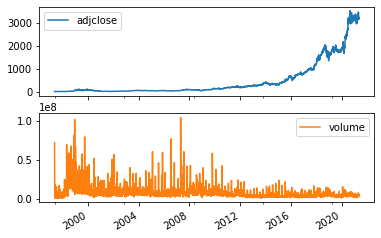

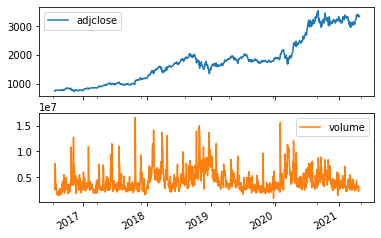

In [27]:
# create these folders if they does not exist
if not os.path.isdir("results"):
    os.mkdir("results")
if not os.path.isdir("logs"):
    os.mkdir("logs")
if not os.path.isdir("data"):
    os.mkdir("data")
    
# load the data
data = load_data(ticker, N_STEPS, scale=SCALE, split_by_date=SPLIT_BY_DATE, 
                shuffle=SHUFFLE, lookup_step=LOOKUP_STEP, test_size=TEST_SIZE, 
                feature_columns=FEATURE_COLUMNS)
data["df"].to_csv(ticker_data_filename)


def show_stock_market(test_df):
    import matplotlib.pyplot as plt
    
    plot_cols = ['adjclose', 'volume']
    plot_features = test_df[plot_cols]
    plot_features.index = pd.to_datetime(test_df.index)
    _ = plot_features.plot(subplots=True)

show_stock_market(data['df'])
show_stock_market(data['test_df'])

# construct the model
model = create_model(N_STEPS, len(FEATURE_COLUMNS), loss=LOSS, units=UNITS, cell=CELL, n_layers=N_LAYERS,
                    dropout=DROPOUT, optimizer=OPTIMIZER, bidirectional=BIDIRECTIONAL)
# some tensorflow callbacks
checkpointer = ModelCheckpoint(os.path.join("results", model_name + ".h5"), save_weights_only=True, save_best_only=True, verbose=1)
tensorboard = TensorBoard(log_dir=os.path.join("logs", model_name))

In [30]:
data['test_df'].tail(10)

,open,high,low,close,adjclose,volume,ticker,adjclose_15,true_adjclose_15,buy_profit,sell_profit
2021-04-12,3355.209961,3395.040039,3351.149902,3379.389893,3379.389893,3281800,AMZN,3192.154297,3386.489990,-187.235596,0.000000
2021-04-13,3400.850098,3432.000000,3395.629883,3400.000000,3400.000000,3315800,AMZN,3193.066406,3311.870117,0.000000,206.933594
2021-04-14,3404.040039,3404.129883,3326.000000,3333.000000,3333.000000,3145200,AMZN,3192.140625,3270.540039,0.000000,140.859375
2021-04-15,3371.000000,3397.000000,3352.000000,3379.090088,3379.090088,3233600,AMZN,3191.526123,3306.370117,0.000000,187.563965
2021-04-16,3380.000000,3406.800049,3355.590088,3399.439941,3399.439941,3183300,AMZN,3190.372559,3291.610107,0.000000,209.067383
2021-04-19,3390.330078,3435.929932,3360.159912,3372.010010,3372.010010,2725400,AMZN,3189.607666,3190.489990,0.000000,182.402344
2021-04-20,3373.600098,3382.989990,3316.000000,3334.689941,3334.689941,2623000,AMZN,3191.878906,3223.909912,0.000000,142.811035
2021-04-21,3316.000000,3362.860107,3303.810059,3362.020020,3362.020020,2211200,AMZN,3190.736572,3151.939941,0.000000,171.283447
2021-04-22,3371.679932,3372.870117,3301.449951,3309.040039,3309.040039,2580600,AMZN,3192.917480,3161.469971,0.000000,116.122559
2021-04-23,3319.100098,3375.000000,3308.500000,3340.879883,3340.879883,3192800,AMZN,3191.933105,3222.899902,0.000000,148.946777


In [ ]:
# train the model and save the weights whenever we see 
# a new optimal model using ModelCheckpoint
history = model.fit(data["X_train"], data["y_train"],
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(data["X_test"], data["y_test"]),
                    callbacks=[checkpointer, tensorboard],
                    verbose=1)

In [33]:
import matplotlib.pyplot as plt

def plot_graph(test_df):
    """
    This function plots true close price along with predicted close price
    with blue and red colors respectively
    """
    plt.plot(test_df[f'true_adjclose_{LOOKUP_STEP}'], c='b')
    plt.plot(test_df[f'adjclose_{LOOKUP_STEP}'], c='r')
    plt.xlabel("Days")
    plt.ylabel("Price")
    plt.legend(["Actual Price", "Predicted Price"])
    plt.show()
    
def get_final_df(model, data):
    """
    This function takes the `model` and `data` dict to 
    construct a final dataframe that includes the features along 
    with true and predicted prices of the testing dataset
    """
    # if predicted future price is higher than the current, 
    # then calculate the true future price minus the current price, to get the buy profit
    buy_profit  = lambda current, true_future, pred_future: true_future - current if pred_future > current else 0
    # if the predicted future price is lower than the current price,
    # then subtract the true future price from the current price
    sell_profit = lambda current, true_future, pred_future: current - true_future if pred_future < current else 0
    X_test = data["X_test"]
    y_test = data["y_test"]
    # perform prediction and get prices
    y_pred = model.predict(X_test)
    if SCALE:
        y_test = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(np.expand_dims(y_test, axis=0)))
        y_pred = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(y_pred))
    test_df = data["test_df"]
    # add predicted future prices to the dataframe
    test_df[f"adjclose_{LOOKUP_STEP}"] = y_pred
    # add true future prices to the dataframe
    test_df[f"true_adjclose_{LOOKUP_STEP}"] = y_test
    # sort the dataframe by date
    test_df.sort_index(inplace=True)
    final_df = test_df
    # add the buy profit column
    final_df["buy_profit"] = list(map(buy_profit, 
                                    final_df["adjclose"], 
                                    final_df[f"adjclose_{LOOKUP_STEP}"], 
                                    final_df[f"true_adjclose_{LOOKUP_STEP}"])
                                    # since we don't have profit for last sequence, add 0's
                                    )
    # add the sell profit column
    final_df["sell_profit"] = list(map(sell_profit, 
                                    final_df["adjclose"], 
                                    final_df[f"adjclose_{LOOKUP_STEP}"], 
                                    final_df[f"true_adjclose_{LOOKUP_STEP}"])
                                    # since we don't have profit for last sequence, add 0's
                                    )
    return final_df

def predict(model, data):
    # retrieve the last sequence from data
    last_sequence = data["last_sequence"][-N_STEPS:]
    # expand dimension
    last_sequence = np.expand_dims(last_sequence, axis=0)
    # get the prediction (scaled from 0 to 1)
    prediction = model.predict(last_sequence)
    # get the price (by inverting the scaling)
    if SCALE:
        predicted_price = data["column_scaler"]["adjclose"].inverse_transform(prediction)[0][0]
    else:
        predicted_price = prediction[0][0]
    return predicted_price

Future price after 15 days is 3204.15$
huber_loss loss: 0.000360015343176201
Mean Absolute Error: 71.07319804007545
Accuracy score: 0.9431438127090301
Total buy profit: 508731.2099609375
Total sell profit: 473081.0419921875
Total profit: 981812.251953125
Profit per trade: 820.9132541414089


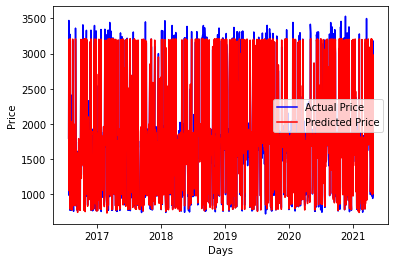

,open,high,low,close,adjclose,volume,ticker,adjclose_15,true_adjclose_15,buy_profit,sell_profit
2021-04-12,3355.209961,3395.040039,3351.149902,3379.389893,3379.389893,3281800,AMZN,1588.369873,1617.209961,0.0,1791.020020
2021-04-13,3400.850098,3432.000000,3395.629883,3400.000000,3400.000000,3315800,AMZN,3211.253662,3190.550049,0.0,188.746338
2021-04-14,3404.040039,3404.129883,3326.000000,3333.000000,3333.000000,3145200,AMZN,1800.822388,1777.079956,0.0,1532.177612
2021-04-15,3371.000000,3397.000000,3352.000000,3379.090088,3379.090088,3233600,AMZN,1877.848877,1755.250000,0.0,1501.241211
2021-04-16,3380.000000,3406.800049,3355.590088,3399.439941,3399.439941,3183300,AMZN,3207.233887,3110.870117,0.0,192.206055
2021-04-19,3390.330078,3435.929932,3360.159912,3372.010010,3372.010010,2725400,AMZN,992.457825,965.900024,0.0,2379.552185
2021-04-20,3373.600098,3382.989990,3316.000000,3334.689941,3334.689941,2623000,AMZN,1593.039673,1447.339966,0.0,1741.650269
2021-04-21,3316.000000,3362.860107,3303.810059,3362.020020,3362.020020,2211200,AMZN,1002.743164,939.789978,0.0,2359.276855
2021-04-22,3371.679932,3372.870117,3301.449951,3309.040039,3309.040039,2580600,AMZN,2985.466064,3182.629883,0.0,323.573975
2021-04-23,3319.100098,3375.000000,3308.500000,3340.879883,3340.879883,3192800,AMZN,1209.214600,1177.619995,0.0,2131.665283


In [34]:
# load optimal model weights from results folder
model_path = os.path.join("results", '2021-05-08_trained_model') + ".h5"
model.load_weights(model_path)

# evaluate the model
loss, mae = model.evaluate(data["X_test"], data["y_test"], verbose=0)
# calculate the mean absolute error (inverse scaling)
if SCALE:
    mean_absolute_error = data["column_scaler"]["adjclose"].inverse_transform([[mae]])[0][0]
else:
    mean_absolute_error = mae
    
# get the final dataframe for the testing set
final_df = get_final_df(model, data)

# predict the future price
future_price = predict(model, data)

# we calculate the accuracy by counting the number of positive profits
accuracy_score = (len(final_df[final_df['sell_profit'] > 0]) + len(final_df[final_df['buy_profit'] > 0])) / len(final_df)
# calculating total buy & sell profit
total_buy_profit  = final_df["buy_profit"].sum()
total_sell_profit = final_df["sell_profit"].sum()
# total profit by adding sell & buy together
total_profit = total_buy_profit + total_sell_profit
# dividing total profit by number of testing samples (number of trades)
profit_per_trade = total_profit / len(final_df)

# printing metrics
print(f"Future price after {LOOKUP_STEP} days is {future_price:.2f}$")
print(f"{LOSS} loss:", loss)
print("Mean Absolute Error:", mean_absolute_error)
print("Accuracy score:", accuracy_score)
print("Total buy profit:", total_buy_profit)
print("Total sell profit:", total_sell_profit)
print("Total profit:", total_profit)
print("Profit per trade:", profit_per_trade)

# plot true/pred prices graph
plot_graph(final_df)
final_df.tail(10)